In [1]:

import torch
import json
import os
import numpy as np
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
from pdf2image import convert_from_path
import tempfile
from pytesseract import Output
import cv2
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_trf
import tensorflow as tf
import pandas as pd
from subprocess import call
import subprocess
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
import uuid
import gc
from tqdm import tqdm
from tqdm import trange
from time import sleep
import adabound

nlp = spacy.load("en_core_web_trf")


def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent


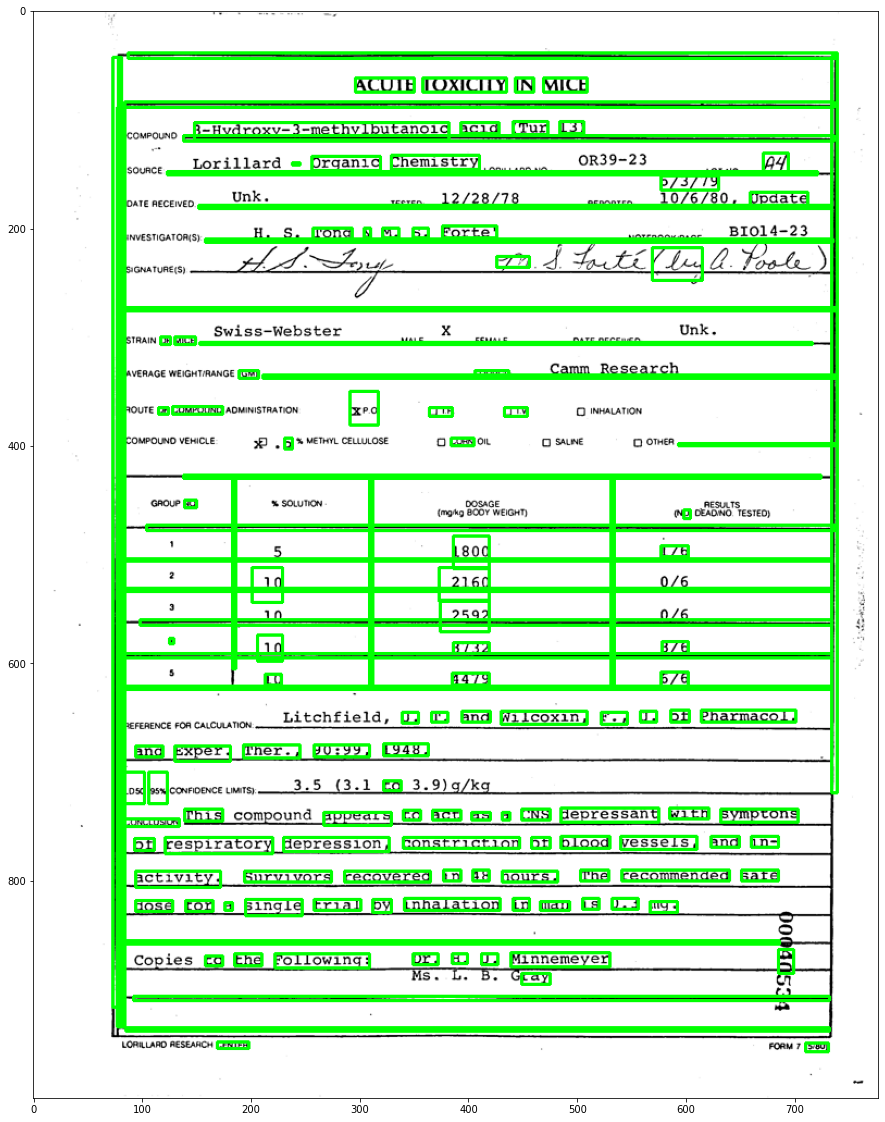

In [2]:
img = cv2.imread("./noisy_documents_dataset/training_data/images/00040534.png")
results = pytesseract.image_to_data(img, output_type=Output.DICT)
for i in range(0, len(results["text"])):
	# extract the bounding box coordinates of the text region from
	# the current result
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
	# extract the OCR text itself along with the confidence of the
	# text localization
    text = results["text"][i]
    conf = int(results["conf"][i])
    if conf > 50:
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        #cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,1.2, (0, 0, 255), 3)


plt.figure(figsize=(20 , 20))
plt.imshow(img)
plt.show()


In [3]:
img = cv2.imread('./noisy_documents_dataset/training_data/images/00040534.png')
results = pytesseract.image_to_string(img , output_type=Output.STRING)
doc = nlp(results)
print([(X.text, X.label_) for X in doc.ents])



[('10 2160 0/6', 'CARDINAL'), ('10 2592 0/6', 'CARDINAL'), ('10 3732 3/6', 'CARDINAL'), ('10 4479 6/6', 'CARDINAL'), ('Wilcoxin', 'PERSON'), ('90:99', 'CARDINAL'), ('48 hours', 'TIME'), ('0.3 mg', 'QUANTITY')]


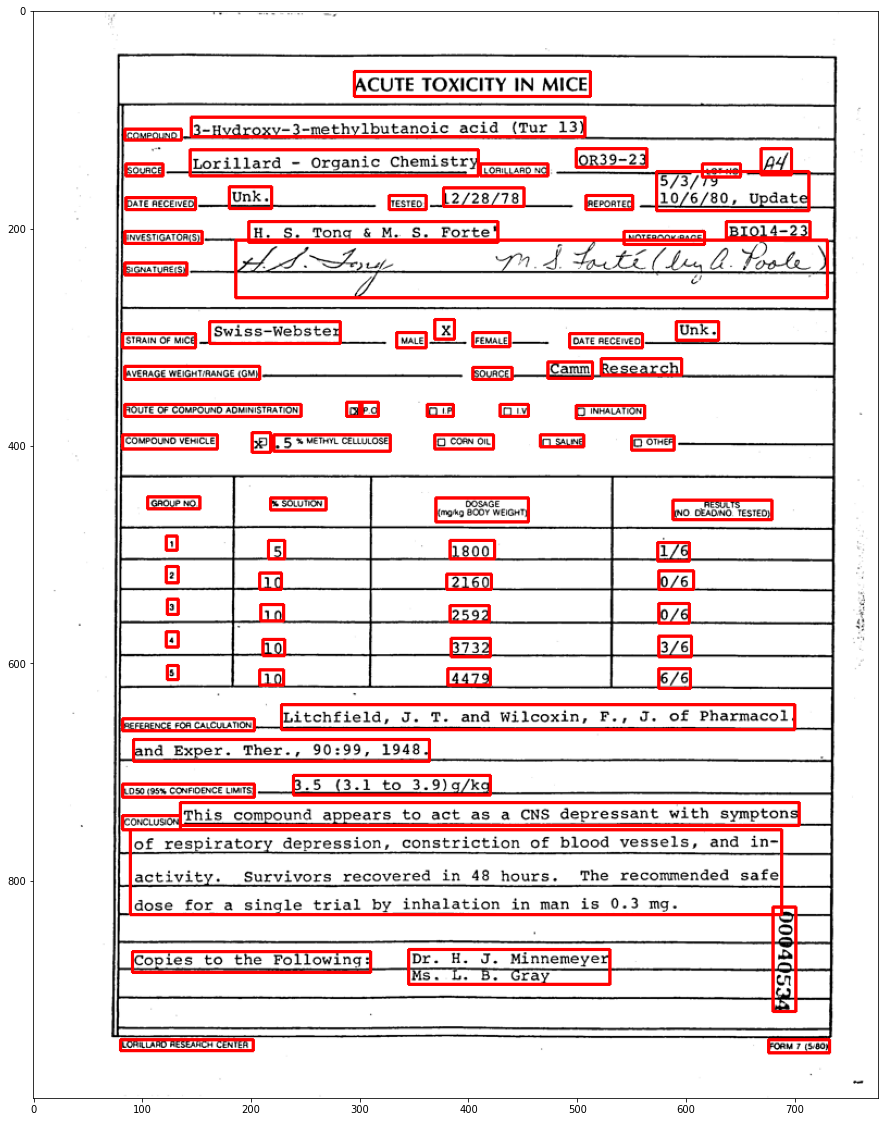

In [4]:
test_img = cv2.imread("./noisy_documents_dataset/training_data/images/00040534.png")
test_json_file = open("./noisy_documents_dataset/training_data/annotations/00040534.json")
test_file_dict = json.load(test_json_file)
for values in test_file_dict["form"]:
    box = values["box"]
    cv2.rectangle(test_img , (box[0] , box[1]) , (box[2] , box[3]) , (255 , 0 , 0) , 2)


    
plt.figure(figsize=(20 , 20))
plt.imshow(test_img)
plt.show()



In [5]:
#this method and the next block was to see if we could first combine the boxes that are given to generate a larger bounding box that contains all of the linked information.
def combine_two_boxes(box1: [int] , box2:[int]) -> [int]:
    x1_left = box1[0]
    x1_right = box1[2]
    y1_top = box1[1]
    y1_bottom = box1[3]
    x2_left = box2[0]
    x2_right = box2[2]
    y2_top = box2[1]
    y2_bottom = box2[3]
    x_new_left = min((x1_left , x2_left))
    x_new_right = max((x1_right , x2_right))
    y_new_bottom = max((y1_bottom , y2_bottom))
    y_new_top = min((y1_top , y2_top))
    return [x_new_left , y_new_top , x_new_right , y_new_bottom]


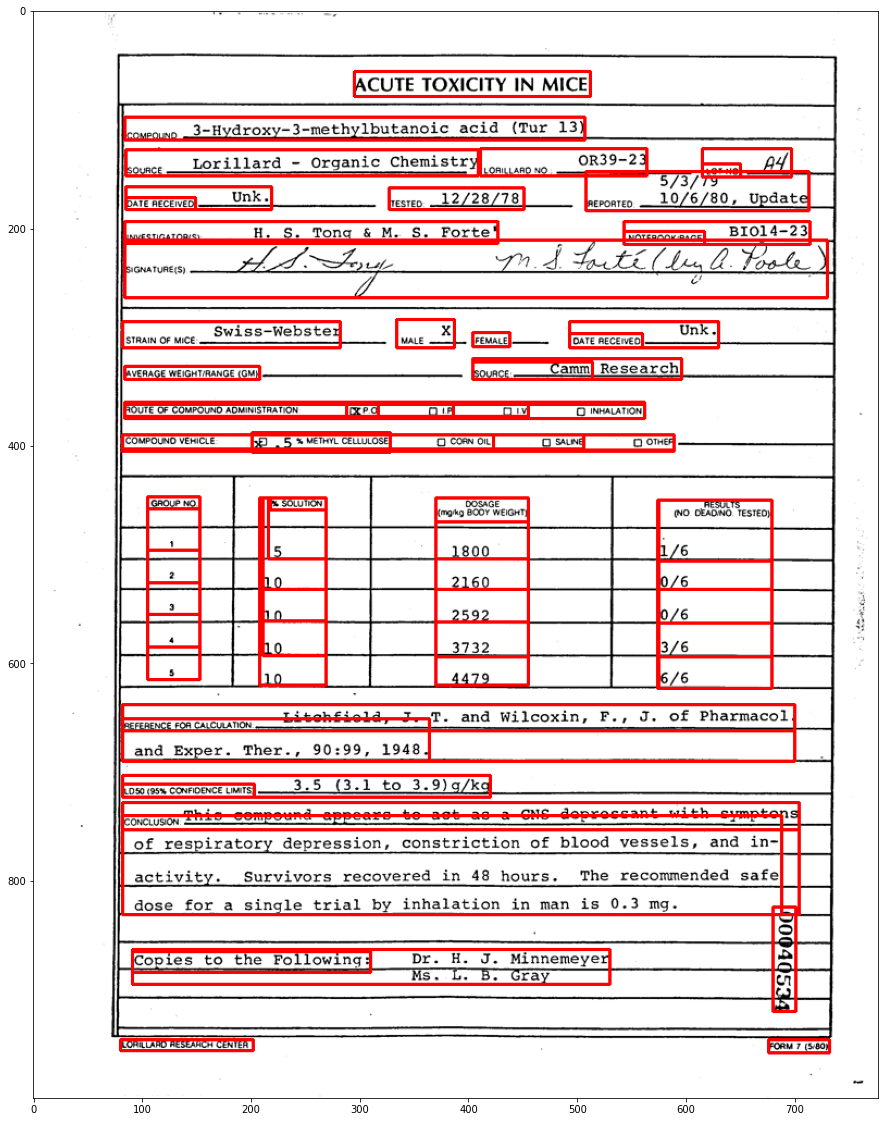

In [6]:
test_combined_img = cv2.imread("./noisy_documents_dataset/training_data/images/00040534.png")
test_combined_json = open("./noisy_documents_dataset/training_data/annotations/00040534.json")
test_combined_dict = json.load(test_combined_json)
already_combined_id = []
counter = 0
form_dict_list = test_combined_dict["form"]
while(len(already_combined_id) < len(form_dict_list)):
    first_bound_dict = form_dict_list[counter]
    curr_box = form_dict_list[counter]["box"]
    curr_box_link = form_dict_list[counter]['linking']
    for links in curr_box_link:
        for link in links:
            if link not in already_combined_id:
                link_box = form_dict_list[link]["box"]
                curr_box = combine_two_boxes(link_box , curr_box)

    cv2.rectangle(test_combined_img, (curr_box[0] , curr_box[1]) , (curr_box[2] , curr_box[3]) , (255 , 0 , 0) , 2)
    counter += 1
    already_combined_id.append(link)

plt.figure(figsize=(20 , 20))
plt.imshow(test_combined_img)
plt.show()

In [7]:
def get_masked(image , annotation):
    already_combined_id = []
    counter = 0
    form_dict_list = annotation["form"]
    while(len(already_combined_id) < len(form_dict_list)):
        first_bound_dict = form_dict_list[counter]
        curr_box = form_dict_list[counter]["box"]
        curr_box_link = form_dict_list[counter]['linking']
        for links in curr_box_link:
            for link in links:
                link_box = form_dict_list[link]["box"]
                curr_box = combine_two_boxes(link_box , curr_box)

        cv2.rectangle(image, (curr_box[0] , curr_box[1]) , (curr_box[2] , curr_box[3]) , (255 , 0 , 0) , 2)
        already_combined_id.append(counter)
        counter += 1
    return image





In [8]:
def generate_masked_training_images():
    image_path = "./noisy_documents_dataset/training_data/images/"
    annotation_path = "./noisy_documents_dataset/training_data/annotations/"
    outPath = "./noisy_documents_dataset/training_data/masked_images/"
    for images in os.listdir(image_path):
        image_file = image_path+images
        file_name = images.strip(".png") + ".json"
        annotation_file = annotation_path + file_name
        json_dict = json.load(open(annotation_file))
        image = cv2.imread(image_file)
        new_image = get_masked(image , json_dict)
        new_image_name = outPath+images
        cv2.imwrite(new_image_name, new_image)

In [9]:
def create_csv_training():
    image_path = "./noisy_documents_dataset/training_data/images/"
    annotation_path = "./noisy_documents_dataset/training_data/annotations/"
    outPath = "./noisy_documents_dataset/training_data/masked_images/"
    id_list = []
    image_list = []
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    label = []
    counter = uuid.uuid4().__str__()
    for images in os.listdir(image_path):
        image_file = image_path+images
        file_name_id = images.strip(".png")
        file_name = images.strip(".png") + ".json"
        annotation_file = annotation_path + file_name
        json_dict = json.load(open(annotation_file))
        box_list = json_dict["form"]
        for i in box_list:
            id_list.append(file_name_id)
            x_top = i["box"][0]
            y_top = i["box"][1]
            x_bottom = i["box"][2]
            y_bottom = i["box"][3]
            box_label = i["label"]
            image_list.append(image_file)
            x1.append(x_top)
            y1.append(y_top)
            x2.append(x_bottom)
            y2.append(y_bottom)
            label.append(box_label)
        counter = uuid.uuid4().__str__()
    df = pd.DataFrame(list(zip(id_list,image_list , x1 , y1 , x2 , y2 , label)))
    return df


In [10]:
def create_csv_testing():
    image_path = "./noisy_documents_dataset/testing_data/images/"
    annotation_path = "./noisy_documents_dataset/testing_data/annotations/"
    outPath = "./noisy_documents_dataset/testing_data/masked_images/"
    id_list = []
    image_list = []
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    label = []
    counter = uuid.uuid4().__str__()
    for images in os.listdir(image_path):
        image_file = image_path+images
        file_name_id = images.strip(".png")
        file_name = images.strip(".png") + ".json"
        annotation_file = annotation_path + file_name
        json_dict = json.load(open(annotation_file))
        box_list = json_dict["form"]
        for i in box_list:
            id_list.append(file_name_id)
            x_top = i["box"][0]
            y_top = i["box"][1]
            x_bottom = i["box"][2]
            y_bottom = i["box"][3]
            box_label = i["label"]
            image_list.append(image_file)
            x1.append(x_top)
            y1.append(y_top)
            x2.append(x_bottom)
            y2.append(y_bottom)
            label.append(box_label)
        counter = uuid.uuid4().__str__()
    df = pd.DataFrame(list(zip(id_list,image_list , x1 , y1 , x2 , y2 , label)))
    return df

In [11]:
def generat_save_training_csv():
    dataframe = create_csv_training()
    dataframe.to_csv("./noisy_documents_dataset/training_data/data.csv", index=False , header=["image_id","image_path" , "x1" , "y1" , "x2" , "y2" , "label"])


In [12]:
def generat_save_testing_csv():
    dataframe = create_csv_testing()
    dataframe.to_csv("./noisy_documents_dataset/testing_data/data.csv" , index=False , header=["image_id","image_path" , "x1" , "y1" , "x2" , "y2" , "label"])

In [13]:
generat_save_training_csv()
generat_save_testing_csv()

In [14]:
class TrainDataset(Dataset):
        def __init__(self , annotation_file):
            super().__init__()
            self.df = pd.read_csv(annotation_file)
            self.image_ids = self.df["image_id"].unique()
            print("created train dataset")
        
        def __getitem__(self , index:int):
            label = ["question", "answer" , "header", "other"]
            image_id = self.image_ids[index]
            records = self.df[self.df['image_id'] == image_id]
            path  = 'noisy_documents_dataset/training_data/images/{0}.png'.format(image_id)
            img = cv2.imread(path , cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB).astype(np.float32)
            img /= 255.0
            boxes = records[['x1', 'y1', 'x2', 'y2']].values
            boxes = torch.as_tensor(boxes , dtype=torch.float32)
            #labels = records[['label']].values
            labels = torch.ones((records.shape[0],), dtype=torch.int64)
            background = torch.zeros((records.shape[0],), dtype= torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['is_background'] = background
            target['image_id'] = torch.tensor([index])

            image = torchvision.transforms.ToTensor()(img)
            return image , target
        
        def __len__(self):
            return self.image_ids.shape[0]


In [15]:
train_dataset = TrainDataset('noisy_documents_dataset/training_data/data.csv')

def collate_fn(batch):
    return tuple(zip(*batch))


train_data_loader = DataLoader(train_dataset , batch_size = 1, shuffle = True , num_workers = 1 , collate_fn = collate_fn)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


created train dataset


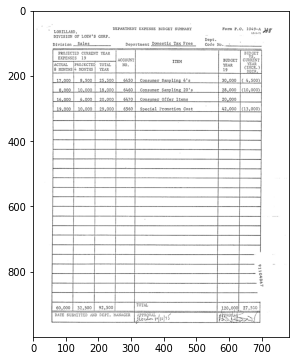

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


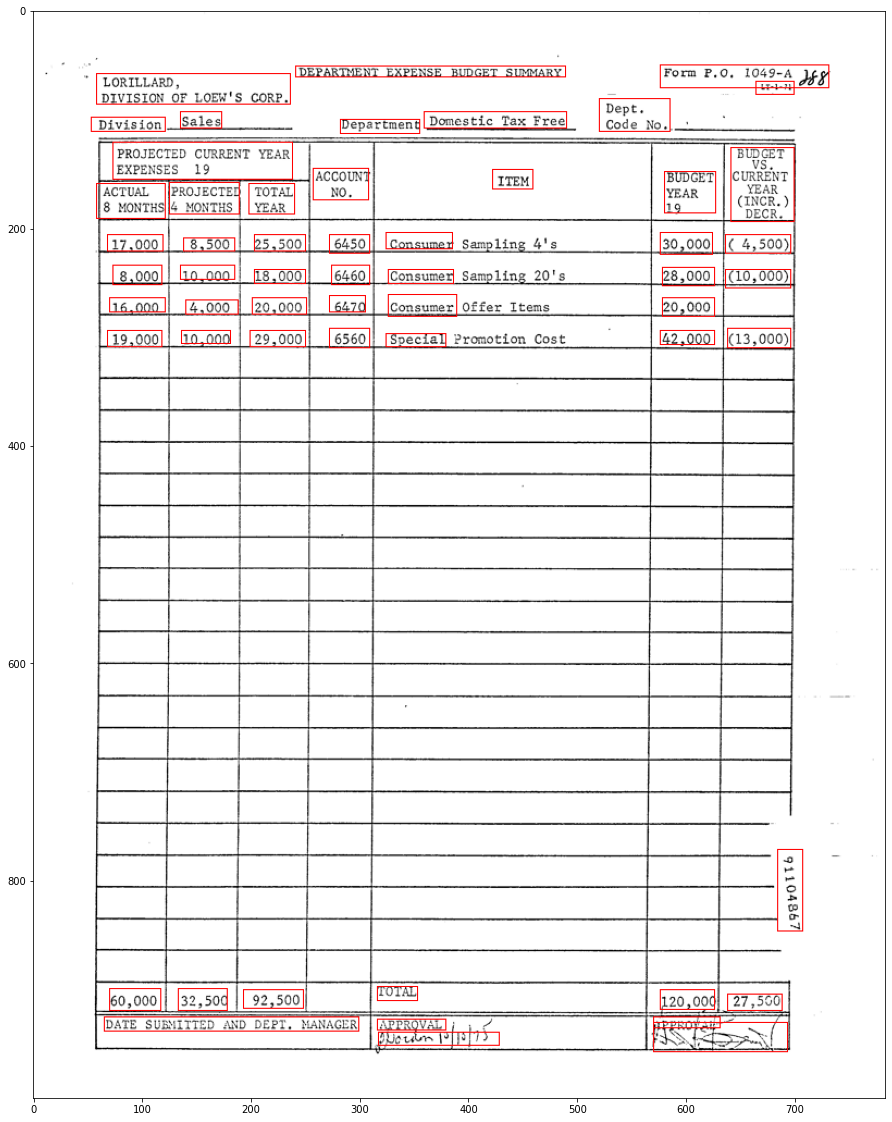

In [16]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets =   [{k: v.to(device) for k , v in t.items()} for t in targets]
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
#label = targets[0]['labels'].cpu().numpy().astype(np.int32)
#print(label)
label_list = ["question", "answer" , "header", "other"]
img = images[0].permute(1 , 2 , 0).cpu().numpy()
fig , ax = plt.subplots(1 , 1 , figsize=(12 , 6))
plt.imshow(img)
plt.show()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
counter = 0
for box in boxes:
    cv2.rectangle(img , (box[0], box[1]) , (box[2] , box[3]) , (255, 0 , 0))
    #cv2.putText(img , label_list[label[counter]-1] , (box[0], box[1]) , cv2.FONT_HERSHEY_COMPLEX_SMALL , 1 , (0 , 255 , 0) , 2 , cv2.LINE_AA)
    counter += 1

plt.figure(figsize=(20 , 20))
plt.imshow(img)
plt.show()


In [17]:
torch.cuda.empty_cache()
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
model.to(device)#using an untrained backbone rather than a pre-trained one for testing


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [18]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.7, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 40

In [19]:
itr = 1
for epoch in range(num_epochs):
    with tqdm(train_data_loader , unit="batch") as tepoch:
        running_loss = 0
        for images , targets in tepoch:
            tepoch.set_description("epoch: {0}".format(epoch))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k , v in t.items()} for t in targets]
            loss_dict = model(images , targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            running_loss = running_loss + losses
            optimizer.zero_grad() #reset for each epoch
            losses.backward()
            optimizer.step()
            """
            if itr % 50 == 0:
                print(f"Iteration #{itr} loss:{loss_value}")
                p
            itr += 1
            """
            
            lr_scheduler.step()
            running_loss += loss_value
            tepoch.set_postfix(loss=losses.item())
        tepoch.set_postfix(loss= running_loss/149)
        sleep(0.1)

    #print("Epuch #{0} loss: {1}".format(epoch , loss_value))

epoch: 15:   1%|          | 1/149 [00:05<12:37,  5.12s/batch, loss=2.2]


KeyboardInterrupt: 

In [20]:
torch.save(model.state_dict() , './model_sgd_resnet50_pretrained_2_classes.pt')

In [3]:


torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 5)
model.to(device)
model.load_state_dict(torch.load('./model_adam_resnet50.pt'))
model.eval()




FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [5]:
torch.cuda.empty_cache()
test_img = cv2.imread("noisy_documents_dataset/testing_data/images/85629964.png" , cv2.IMREAD_COLOR)
test_img = cv2.cvtColor(test_img , cv2.COLOR_BGR2RGB).astype(np.float32)
test_img /= 255.0
test_img = torchvision.transforms.ToTensor()(test_img)
test_img.to(device)
test_img = test_img.unsqueeze(1).to(device)
print(test_img.shape)
output = model(test_img)
boxes = output[0]['boxes'].data.cpu().numpy()
test_img = test_img[0].permute(1 , 2 , 0).cpu().numpy()
print(boxes , len(boxes))

torch.Size([3, 1000, 777, 1])


RuntimeError: The size of tensor a (1000) must match the size of tensor b (3) at non-singleton dimension 0

In [ ]:
for box in boxes:
    